<a href="https://www.kaggle.com/code/archismancoder/binarypredpoisonousmushrooms-tfdf?scriptVersionId=191915707" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [4]:
df_train.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [5]:
df_train.duplicated().sum()

0

## MEMORY OPTIMIZATION

In [6]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [7]:
# df_train = reduce_memory_usage(df_train)
# df_test = reduce_memory_usage(df_test)

# VISUALIZATION

In [8]:
df_train.shape

(3116945, 22)

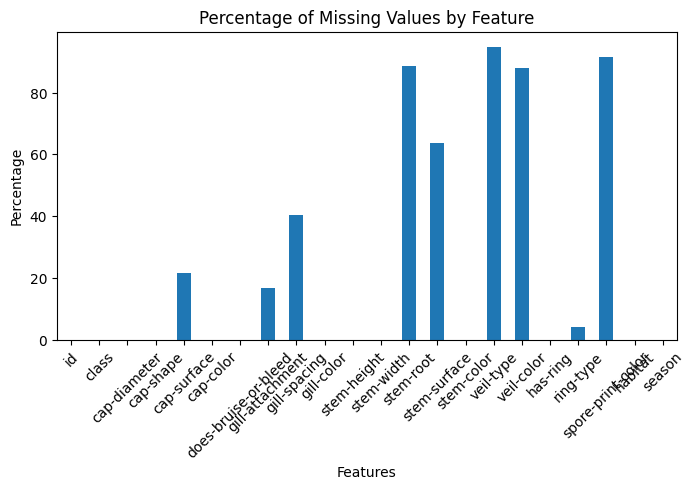

In [9]:
import matplotlib.pyplot as plt

missing_values = df_train.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(8, 4))

plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

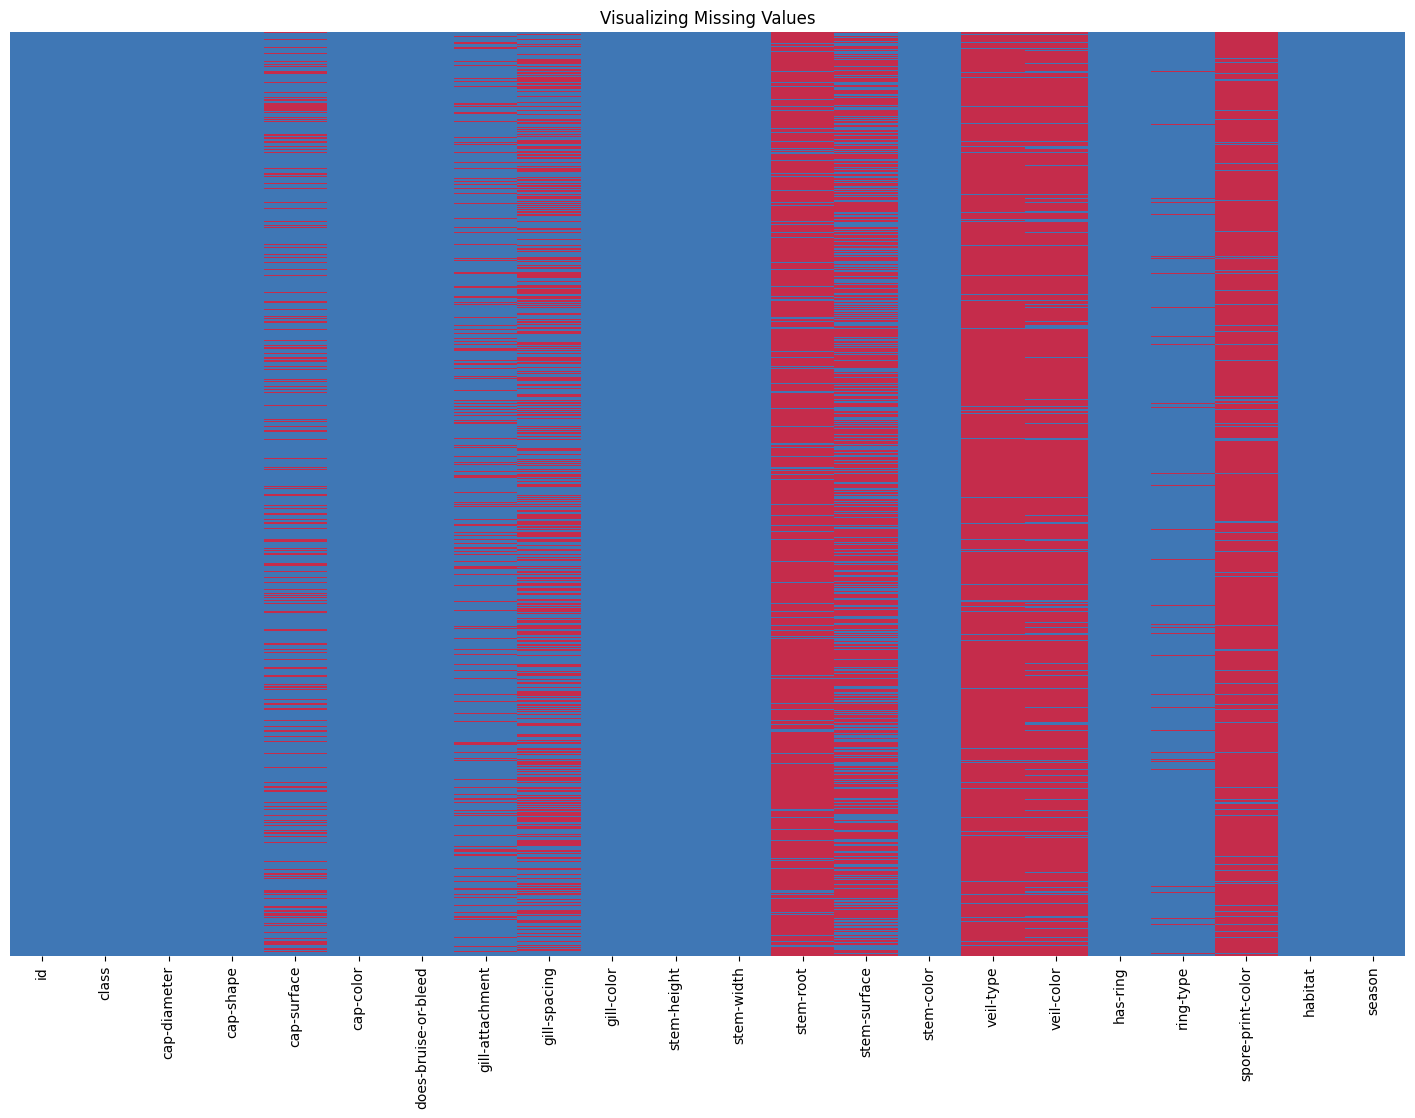

In [10]:
import seaborn as sns

plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, cmap=sns.color_palette("Spectral_r", n_colors=13), yticklabels=False);

In [11]:
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'category' and col != 'class']
continuous_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float16']
FEATURES = [col for col in df_train.columns if col not in ['id', 'class']]
TARGET = 'class'

In [12]:
# sns.set_style('darkgrid')

def categorical_distributions_plot(df, cols, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 32))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        temp = df[col].value_counts().nlargest(10).reset_index()
        temp.columns = [col, 'count']
        sns.barplot(y=col, x='count', data=temp, palette='Set2', ax=ax, order=temp[col])
        
        ax.set_xlabel('Count', fontsize=12)
        ax.set_ylabel(col, fontsize=12)
        ax.set_title(f'Distribution of {col}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
    
    fig.tight_layout()
    plt.show()


In [13]:
categorical_distributions_plot(df_train, categorical_cols)

<Figure size 1600x3200 with 0 Axes>

In [14]:
def categorical_vs_target_plot(df, cols, target, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 14))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        target_distribution = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)
        top_categories = df[col].value_counts().nlargest(10).index
        target_distribution = target_distribution.loc[top_categories]
        target_distribution = target_distribution.sort_values(by=target_distribution.columns.tolist(), ascending=False)
        target_distribution.plot(kind='bar', stacked=True, colormap='Set2', edgecolor='black', alpha=0.7, ax=ax)
        
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Proportion', fontsize=12)
        ax.set_title(f'{col} and {target}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        ax.legend(title=target, fontsize=10)
    
    fig.tight_layout()
    plt.show()

In [15]:
categorical_vs_target_plot(df_train, categorical_cols, 'class')

<Figure size 1600x1400 with 0 Axes>

# PREPROCESSING

In [16]:
df_train.drop(['id'], axis = 1, inplace = True)
df_test.drop(['id'], axis = 1, inplace = True)

In [17]:
df_train['class'] = df_train['class'].map({'p': 1, 'e': 0})

In [18]:
for col in categorical_cols:
    if col in FEATURES:
        df_train[col] = df_train[col].astype(str).fillna('NaN')
        df_test[col] = df_test[col].astype(str).fillna('NaN')

In [19]:
df_train[FEATURES].head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [20]:
df_train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,0,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,0,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,0,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,0,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,1,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,0,9.45,p,i,n,t,e,NaN,p,9.13,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


# MODEL

## TFDF MODEL

### TRAIN & VALIDATION SPLITTING

In [21]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-08-10 11:50:30.690598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 11:50:30.690696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 11:50:30.815326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
def test_train_split(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, validation_ds_pd = test_train_split(df_train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(validation_ds_pd)))

2181587 examples in training, 935358 examples in testing.


In [23]:
validation_ds_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935358 entries, 3 to 3116944
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   class                 935358 non-null  int64  
 1   cap-diameter          935354 non-null  float64
 2   cap-shape             935350 non-null  object 
 3   cap-surface           734142 non-null  object 
 4   cap-color             935355 non-null  object 
 5   does-bruise-or-bleed  935356 non-null  object 
 6   gill-attachment       778468 non-null  object 
 7   gill-spacing          557190 non-null  object 
 8   gill-color            935337 non-null  object 
 9   stem-height           935358 non-null  float64
 10  stem-width            935358 non-null  float64
 11  stem-root             107680 non-null  object 
 12  stem-surface          339914 non-null  object 
 13  stem-color            935348 non-null  object 
 14  veil-type             47971 non-null   object 
 15  veil

In [24]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=TARGET, task = tfdf.keras.Task.CLASSIFICATION)
validation_ds = tfdf.keras.pd_dataframe_to_tf_dataset(validation_ds_pd, label=TARGET, task = tfdf.keras.Task.CLASSIFICATION)

In [25]:
train_ds

<_PrefetchDataset element_spec=({'cap-diameter': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'cap-shape': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'cap-surface': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'cap-color': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'does-bruise-or-bleed': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'gill-attachment': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'gill-spacing': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'gill-color': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'stem-height': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'stem-width': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'stem-root': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'stem-surface': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'stem-color': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'veil-type': TensorSpec(shape=(None,), dtype=tf

In [26]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [27]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
rf.compile()

Use /tmp/tmpyr55h6d9 as temporary training directory


In [28]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:23.748826. Found 2181587 examples.
Training model...


[INFO 24-08-10 12:03:26.4759 UTC kernel.cc:1233] Loading model from path /tmp/tmpyr55h6d9/model/ with prefix 988b693b069c4114
[INFO 24-08-10 12:03:34.5539 UTC decision_forest.cc:660] Model loaded with 300 root(s), 2115936 node(s), and 20 input feature(s).
[INFO 24-08-10 12:03:34.5539 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-10 12:03:34.5540 UTC kernel.cc:1061] Use fast generic engine


Model trained in 0:12:17.344640
Compiling model...
Model compiled.


In [29]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=5)

In [30]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=2181587, accuracy=0.9897634153485513, loss=0.11756507251050932, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [31]:
evaluation = rf.evaluate(x=validation_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

936/936 [==============================] - 67s 68ms/step - loss: 0.0000e+00
loss: 0.0000


In [32]:
evaluation

{'loss': 0.0}

# TESTING

In [33]:
df_test_tfdf = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
ids = df_test_tfdf.pop('id')

In [34]:
test_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(
    df_test_tfdf,
    task = tfdf.keras.Task.CLASSIFICATION)

preds = rf.predict(test_ds_tf)

output = pd.DataFrame({'id': ids,
                       'class': preds.squeeze()})

output.head()

2078/2078 [==============================] - 142s 68ms/step


,id,class
0,3116945,0.020000
1,3116946,0.936666
2,3116947,0.999999
3,3116948,0.999999
4,3116949,0.000000


In [35]:
y_pred = np.where(preds>0.5,1,0)

In [36]:
output2 = pd.DataFrame({'id': ids,
                       'class': y_pred.squeeze()})

In [37]:
output2["class"] = np.where(output2["class"] == 1, 'p', 'e')
output_test_tfdf = output2

In [38]:
output_test_tfdf.head(10)

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
5,3116950,e
6,3116951,e
7,3116952,p
8,3116953,p
9,3116954,e


In [39]:
output_test_tfdf.to_csv('submission_tfdf.csv', index=False)